This notebook examines correlations between sky factors (moon distance, moon illumination, seeing, and zero-point magnitude) and the number of "good" (R/B > 0.6) object detections per exposure.

In [9]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from astropy.coordinates import get_moon, GCRS
import astropy.units as u

In [10]:
dbuser = 'kennedyt' # input("DB User: ")
dbpasswd = 'loq81a5ocd6m' # getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

#### How does the distance to the moon affect the number of good detections? (COSMOS)

In [11]:
query = ( 'SELECT o.id, s.exposure_id, e.mjd, e.ra, e.dec, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

moonquery = np.array( cursor.fetchall() ).transpose()

In [12]:
# Counting the number of objects in each exposure (objs) and masking the dates, filters, and coordinates to match
exps, indices, objs = np.unique( moonquery[1], return_counts=True, return_index=True )
mjds = moonquery[2][indices].astype(np.float)
filters = moonquery[5][indices]
obs_coords = GCRS( ra = moonquery[3][indices].astype(np.float)*u.deg, dec = moonquery[4][indices].astype(np.float)*u.deg, representation_type=None )

# Putting it into a Pandas DataFrame to keep better track of what is what
moon_df = pd.DataFrame(np.array([exps,objs,filters,mjds, obs_coords]).transpose(), columns = ['ExpID', 'Objs', 'Filter', 'MJD', 'ObsCoords'])

In [13]:
# Calculate the Moon's coordinates at time of observation and put them into a new column
moon_df['MJD'] = [Time(i, format='mjd') for i in moon_df['MJD']]
moon_df["MoonCoords"] = [get_moon(i) for i in moon_df['MJD']]

In [14]:
# Calculate the great circle distance separation between the observation and the Moon and put it in a new column
moon_df['MoonSep'] = [moon_df['ObsCoords'][i].separation(moon_df['MoonCoords'][i]) for i in range(len(moon_df['ExpID']))]
moon_df['MoonSep'] = [i.value for i in moon_df['MoonSep']]

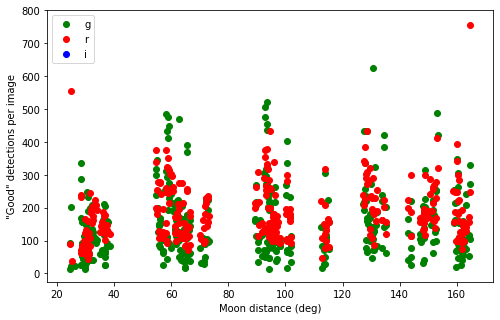

In [15]:
# Create masks for different filters
gmsk = np.where(moon_df["Filter"]=='g')[0]
rmsk = np.where(moon_df["Filter"]=='r')[0]
imsk = np.where(moon_df["Filter"]=='i')[0]

# Plot
plt.figure(figsize=(8,5))
plt.scatter(moon_df['MoonSep'][gmsk], moon_df['Objs'][gmsk], color='g', label='g')
plt.scatter(moon_df['MoonSep'][rmsk], moon_df['Objs'][rmsk], color='r', label='r')
plt.scatter(moon_df['MoonSep'][imsk], moon_df['Objs'][imsk], color='b', label='i')
plt.xlabel('Moon distance (deg)')
plt.ylabel('"Good" detections per image')
plt.legend();

#### How does the distance to the moon affect the number of good detections? (COSMOS) (This section uses the 'moondata.txt' lookup table but gets the same result as above, so I have it commented out)

In [16]:
# query = ( 'SELECT o.candidate_id, e.filename, e.filter FROM objects o '
#          'JOIN subtractions s ON o.subtraction_id=s.id '
#          'JOIN exposures e ON e.id=s.exposure_id '
#          'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
#          'AND o.rb>0.6 '
#          'LIMIT 10000000' )

# cursor.execute( query )

# moonquery2 = np.array( cursor.fetchall() ).transpose()

In [17]:
# fnms = [moonquery2[1][i][:21] for i in range(len(moonquery2[1]))] # truncate filenames to match lookup table format
# cands, index, objsperimg = np.unique(moonquery2[1], return_index=True, return_counts=True)
# table = np.loadtxt("moondata.txt", dtype=np.str).transpose()
# fnms = np.array(fnms)[index]
# moondist = np.ones(len(fnms))
# for i in range(len(fnms)):
#     moondist[i] = table[1][np.where(fnms[i] == table[0])[0]]

In [18]:
# # Create masks for different filters
# gmsk = np.where(moonquery2[2][index]=='g')[0]
# rmsk = np.where(moonquery2[2][index]=='r')[0]
# imsk = np.where(moonquery2[2][index]=='i')[0]

In [19]:
# # Plotting it all up, looks the same as before

# plt.figure(figsize=(8,5))
# plt.scatter(moondist[gmsk], objsperimg[gmsk], color='g', label='g')
# plt.scatter(moondist[rmsk], objsperimg[rmsk], color='r', label='r')
# plt.scatter(moondist[imsk], objsperimg[imsk], color='b', label='i')
# plt.xlabel('Moon distance (deg)')
# plt.ylabel('"Good" detections per image')
# plt.legend();

#### How does moon illumination affect the number of good detections per image? (uses lookup table 'moondata.txt')

In [20]:
query = ( 'SELECT o.candidate_id, e.filename, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

moonquery2 = np.array( cursor.fetchall() ).transpose()

In [21]:
fnms = [ moonquery2[1][i][:21] for i in range( len( moonquery2[1] ) ) ] # truncate filenames to match lookup table format
cands, index, objsperimg = np.unique( moonquery2[1], return_index=True, return_counts=True )

moonlt = np.loadtxt( "moondata.txt", dtype=np.str ).transpose()

fnms = np.array( fnms )[index]
illum = np.ones( len( fnms ) )
for i in range( len( fnms ) ):
    illum[i] = moonlt[2][ np.where( fnms[i] == moonlt[0] )[0] ]

In [22]:
# Create masks for different filters
gmsk = np.where( moonquery2[2][index]=='g' )[0]
rmsk = np.where( moonquery2[2][index]=='r' )[0]
imsk = np.where( moonquery2[2][index]=='i' )[0]

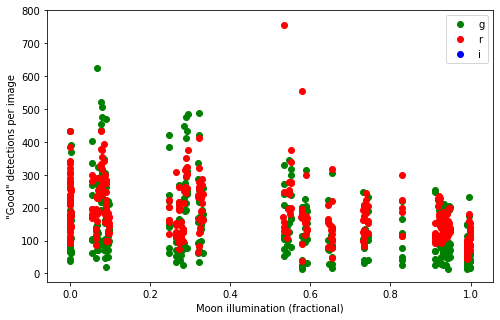

In [23]:
# Plotting it

plt.figure( figsize=(8,5) )
plt.scatter( illum[gmsk], objsperimg[gmsk], color='g', label='g' )
plt.scatter( illum[rmsk], objsperimg[rmsk], color='r', label='r' )
plt.scatter( illum[imsk], objsperimg[imsk], color='b', label='i' )
plt.xlabel( 'Moon illumination (fractional)' )
plt.ylabel( '"Good" detections per image' )
plt.legend();

#### How does median pixel value affect number of good detections? (uses lookup table 'medpixval.txt')

In [24]:
query = ( 'SELECT o.candidate_id, e.filename, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

pixvalquery = np.array( cursor.fetchall() ).transpose()

In [25]:
fnms = [pixvalquery[1][i][:21] for i in range(len(pixvalquery[1]))] # truncate filenames to match lookup table format
cands, index, objsperimg = np.unique(pixvalquery[1], return_index=True, return_counts=True)
pixvallt = np.loadtxt("medpixval.txt", dtype=np.str).transpose()
fnms = np.array(fnms)[index]
pixval = np.ones(len(fnms))
for i in range(len(fnms)):
    pixval[i] = pixvallt[1][np.where(fnms[i] == pixvallt[0])[0]]

In [26]:
# Create masks for different filters
gmsk = np.where(pixvalquery[2][index]=='g')[0]
rmsk = np.where(pixvalquery[2][index]=='r')[0]
imsk = np.where(pixvalquery[2][index]=='i')[0]

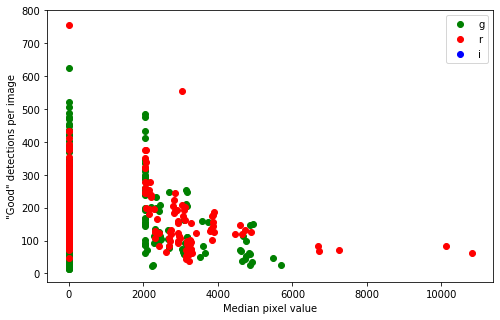

In [27]:
plt.figure(figsize=(8,5))
plt.scatter(pixval[gmsk], objsperimg[gmsk], color='g', label='g')
plt.scatter(pixval[rmsk], objsperimg[rmsk], color='r', label='r')
plt.scatter(pixval[imsk], objsperimg[imsk], color='b', label='i')
plt.xlabel('Median pixel value')
plt.ylabel('"Good" detections per image')
plt.legend();

#### How does seeing affect the number of good detections? (COSMOS)

In [28]:
query = ( 'SELECT o.id, s.id, s.seeing, e.filter, e.id FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

seeingquery = np.array( cursor.fetchall() ).transpose()

In [29]:
expids = seeingquery[4].astype(np.int)
seeing = seeingquery[2].astype(np.float)

# Determine which exposure IDs are present
expids_unique = np.unique(expids)

# Find the average seeing for each exposure
seeing = np.array( [np.mean( seeing[np.where( expids == i )[0]] ) for i in expids_unique] )

In [30]:
# determine how many objects are in each exposure, and create an array of filters resized in the same way
exp, indices, objperimg = np.unique( seeingquery[4], return_counts=True, return_index=True )
filters = seeingquery[3][indices]

In [31]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

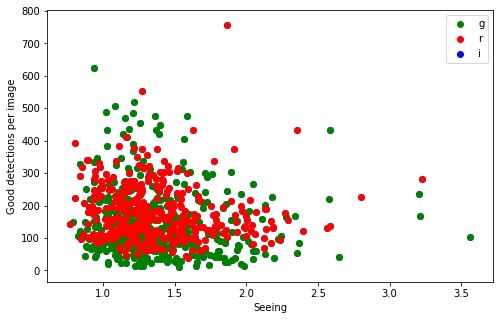

In [32]:
# Plotting it all up
plt.figure(figsize=(8,5))
plt.scatter(seeing, objperimg)
plt.scatter( seeing[gmsk], objperimg[gmsk], color='g', label='g' )
plt.scatter( seeing[rmsk], objperimg[rmsk], color='r', label='r' )
plt.scatter( seeing[imsk], objperimg[imsk], color='b', label='i' )
plt.xlabel( 'Seeing' )
plt.ylabel( 'Good detections per image' )
plt.legend();

#### How does magzp affect number of good detections? (COSMOS)

In [33]:
query = ( 'SELECT o.id, s.id, s.magzp, e.filter, e.id FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

magzpquery = np.array( cursor.fetchall() ).transpose()

In [34]:
expids = magzpquery[4].astype(np.int)
magzp = magzpquery[2].astype(np.float)

# Determine which exposure IDs are present
expids_unique = np.unique(expids)

# Find the average magzp for each exposure
magzp = np.array( [np.mean( magzp[np.where( expids == i )[0]] ) for i in expids_unique] )

In [35]:
# determine how many objects are in each exposure, and create an array of filters resized in the same way
exp, indices, objperimg = np.unique( magzpquery[4], return_counts=True, return_index=True )
filters = magzpquery[3][indices]

In [36]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

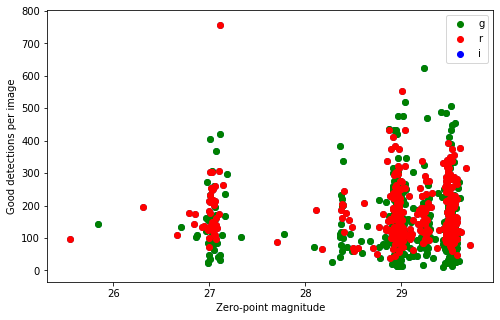

In [37]:
# Plotting it all up
plt.figure(figsize=(8,5))
plt.scatter(magzp, objperimg)
plt.scatter( magzp[gmsk], objperimg[gmsk], color='g', label='g' )
plt.scatter( magzp[rmsk], objperimg[rmsk], color='r', label='r' )
plt.scatter( magzp[imsk], objperimg[imsk], color='b', label='i' )
plt.xlabel( 'Zero-point magnitude' )
plt.ylabel( 'Good detections per image' )
plt.legend();